In [2]:
import pandas as pd
import numpy as np
import datetime 
import re
from urlextract import URLExtract
import spacy
import time
import pickle
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
extractor = URLExtract()
# remove all urls from posts
def replace_urls(x):
    urls = extractor.find_urls(x)
    if urls:
        x_new = replace_urls(x.replace(urls[0],''))
        return x_new
    else:
        return x

In [5]:
# df_full = pd.read_csv('data/sample_depression_large.csv', low_memory=False)
# df_full = pd.read_csv('data/mentalhealth01-18_08-19.csv', low_memory=False)
# df_full = pd.read_csv('data/depression_wrd_vec_lrg.csv', low_memory=False)
# df_full = pd.read_csv('data/suicidewatch.csv', low_memory=False)
df_full = pd.read_csv('data/depression_all.csv', low_memory=False)


In [6]:
df_full.shape

(614661, 33)

In [7]:
df_full = df_full[(df_full['selftext'] != '[deleted]') & (df_full['selftext'] != '[removed]')].copy()
df_full.drop_duplicates(subset=['selftext'], inplace=True)
df_full.drop_duplicates(subset=['id'], inplace=True)

In [8]:
df_full['date'] = df_full.created_utc.apply(lambda x: pd.to_datetime(time.ctime(x)))

In [9]:
df_full.groupby('selftext').size().sort_values(ascending=False).head(50)

selftext
����������                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [10]:
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub("&amp;#x200B;",' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub("&amp;nbsp;",' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub("&amp;",' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub("nbsp;",' ',str(x)))


df_full['selftext'] = df_full.selftext.map(lambda x: re.sub('\n',' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub('  ',' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: replace_urls(x))
# df_full['date'] = df_full.created_utc.apply(lambda x: pd.to_datetime(time.ctime(x)))

In [12]:
df_full['text_title'] = df_full.title + ' ' + df_full.selftext
df_full['text_title'] = df_full['text_title'].apply(lambda x: str(x))
df_full['text_title'] = df_full['text_title'].apply(lambda x: x.lower())

In [199]:
# df_non_null = df_full[(df_full.selftext != '[removed]')&(df_full.selftext != '[deleted]') & (df_full.selftext != 'nan')].copy()

In [200]:
# df_full.groupby('text_title').size().sort_values(ascending=False)


In [13]:
df_full

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,...,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,date,text_title
0,1504779698,depression,ziqkimi,self.depression,https://www.reddit.com/r/depression/comments/6...,2,1,NaN,NaN,Should I stop/leave playing games to focus on ...,...,True,NaN,/r/depression/comments/6ymbsa/should_i_stoplea...,NaN,NaN,NaN,NaN,NaN,2017-09-07 05:21:38,should i stop/leave playing games to focus on ...
3,1538788891,depression,[deleted],self.depression,https://www.reddit.com/r/depression/comments/9...,4,3,NaN,NaN,I wish this empty dead feeling would stop,...,True,NaN,/r/depression/comments/9ls592/i_wish_this_empt...,NaN,NaN,False,NaN,NaN,2018-10-05 20:21:31,i wish this empty dead feeling would stop i ke...
5,1552532765,depression,rollingwththehomies,self.depression,https://www.reddit.com/r/depression/comments/b...,1,1,NaN,NaN,I just want to smile.,...,True,NaN,/r/depression/comments/b0v804/i_just_want_to_s...,NaN,NaN,False,NaN,NaN,2019-03-13 22:06:05,"i just want to smile. unfortunately, i’m sitti..."
6,1506486007,depression,manddddaaaa,self.depression,https://www.reddit.com/r/depression/comments/7...,6,12,NaN,NaN,I wish I had a gun.,...,True,NaN,/r/depression/comments/72pxtr/i_wish_i_had_a_gun/,NaN,NaN,NaN,NaN,NaN,2017-09-26 23:20:07,"i wish i had a gun. only on nights like these,..."
7,1493439517,depression,astrangerstill,self.depression,https://www.reddit.com/r/depression/comments/6...,1,3,NaN,NaN,I literally have no one in my life I can talk to,...,True,NaN,/r/depression/comments/687ive/i_literally_have...,NaN,NaN,False,NaN,NaN,2017-04-28 23:18:37,i literally have no one in my life i can talk ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614650,1496755263,depression,Foreverintherain,self.depression,https://www.reddit.com/r/depression/comments/6...,2,2,NaN,NaN,Shit relationship,...,True,NaN,/r/depression/comments/6flps8/shit_relationship/,NaN,NaN,False,NaN,NaN,2017-06-06 08:21:03,shit relationship anyone feel awkward around c...
614652,1543373606,depression,injustice123456,self.depression,https://www.reddit.com/r/depression/comments/a...,2,7,NaN,NaN,thoughts of killing run through my mind,...,True,NaN,/r/depression/comments/a121ps/thoughts_of_kill...,NaN,NaN,False,NaN,NaN,2018-11-27 20:53:26,thoughts of killing run through my mind for th...
614655,1470941815,depression,90Panda123,self.depression,https://www.reddit.com/r/depression/comments/4...,0,1,1.0,0.0,I'm broken and lost,...,True,NaN,/r/depression/comments/4x9nl6/im_broken_and_lost/,t3_4x9nl6,NaN,False,NaN,NaN,2016-08-11 13:56:55,i'm broken and lost i don't know how to start ...
614657,1520292357,depression,BirthdayThrowaway132,self.depression,https://www.reddit.com/r/depression/comments/8...,0,1,NaN,NaN,I've lost my drive and don't know what to do,...,True,NaN,/r/depression/comments/82afqh/ive_lost_my_driv...,NaN,NaN,NaN,NaN,NaN,2018-03-05 17:25:57,i've lost my drive and don't know what to do f...


<AxesSubplot:xlabel='date,date'>

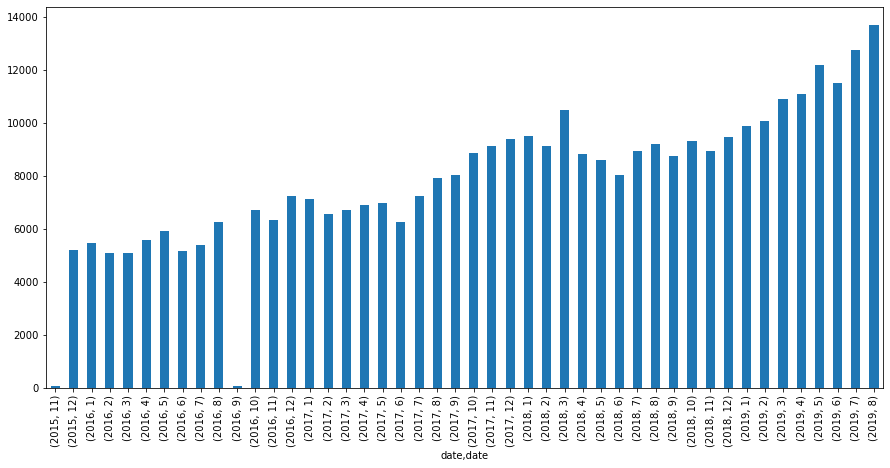

In [15]:
plt.figure(figsize=[15,7])
df_full.groupby([df_full["date"].dt.year, df_full["date"].dt.month]).size().plot(kind="bar")

In [16]:
nlp = spacy.load("en")

In [19]:
# nlp.Defaults.stop_words |= set(additional_stop_words)

In [22]:
df_clean = df_full.reset_index().drop(columns=['index'])
topic_sample = df_clean.sample(80000, random_state=1)
topic_sample

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,...,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,date,text_title
276588,1490204586,depression,InternalizedStresses,self.depression,https://www.reddit.com/r/depression/comments/6...,1,1,NaN,NaN,Where to start....,...,True,NaN,/r/depression/comments/60w4sq/where_to_start/,NaN,NaN,False,NaN,NaN,2017-03-22 12:43:06,"where to start.... reddit, i need help. 31,m -..."
334689,1498504020,depression,eliteephedrine,self.depression,https://www.reddit.com/r/depression/comments/6...,1,3,NaN,NaN,"I am sorry if this is long, but I have no one ...",...,True,NaN,/r/depression/comments/6jn7qa/i_am_sorry_if_th...,NaN,NaN,False,NaN,NaN,2017-06-26 14:07:00,"i am sorry if this is long, but i have no one ..."
131170,1500975031,depression,drewskeeeet,self.depression,https://www.reddit.com/r/depression/comments/6...,6,1,NaN,NaN,Possible side effects of Wellbutrin?,...,True,NaN,/r/depression/comments/6pf21z/possible_side_ef...,NaN,NaN,False,NaN,NaN,2017-07-25 04:30:31,"possible side effects of wellbutrin? sorry, th..."
335275,1463404264,depression,Laura51,self.depression,https://www.reddit.com/r/depression/comments/4...,15,3,3.0,0.0,Anyone else out there who has had ECT?,...,True,NaN,/r/depression/comments/4jl2qf/anyone_else_out_...,t3_4jl2qf,NaN,False,NaN,NaN,2016-05-16 08:11:04,anyone else out there who has had ect? i'm 24....
93307,1540333067,depression,Mr_Piggles329,self.depression,https://www.reddit.com/r/depression/comments/9...,2,2,NaN,NaN,LIFE SUCKS,...,True,NaN,/r/depression/comments/9qtqj4/life_sucks/,NaN,NaN,False,NaN,NaN,2018-10-23 17:17:47,life sucks the first time i was genuinely happ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120779,1545757820,depression,jakemail,self.depression,https://www.reddit.com/r/depression/comments/a...,0,1,NaN,NaN,Social media and depression,...,True,NaN,/r/depression/comments/a9gezj/social_media_and...,NaN,NaN,False,NaN,NaN,2018-12-25 11:10:20,social media and depression we are doing a sim...
245799,1479284563,depression,InsomniaMelody,self.depression,https://www.reddit.com/r/depression/comments/5...,4,1,1.0,0.0,"You was such a happy-go-lucky, easy-going as a...",...,True,NaN,/r/depression/comments/5d85yz/you_was_such_a_h...,t3_5d85yz,NaN,False,NaN,NaN,2016-11-16 02:22:43,"you was such a happy-go-lucky, easy-going as a..."
62551,1558222408,depression,Nerdlinger-Thrillho,self.depression,https://www.reddit.com/r/depression/comments/b...,0,1,NaN,NaN,I’m having a hard time doing the lazy things I...,...,True,NaN,/r/depression/comments/bqa9ji/im_having_a_hard...,NaN,NaN,False,NaN,NaN,2019-05-18 18:33:28,i’m having a hard time doing the lazy things i...
191980,1488268280,depression,Fuckmymomlmao,self.depression,https://www.reddit.com/r/depression/comments/5...,0,3,NaN,NaN,About to go to bed depressed as usual.,...,True,NaN,/r/depression/comments/5wmrkh/about_to_go_to_b...,NaN,NaN,False,NaN,NaN,2017-02-28 01:51:20,about to go to bed depressed as usual. i keep ...


In [23]:
from spacy.lang.en.stop_words import STOP_WORDS

def process_text(nlp, text, pos_list, lemma=False):

    text_full = [] 
    for doc in nlp.pipe(text, disable=['parser', 'ner', 'tagger']):
        # if part of speech list isnt empty return matches for pos
        if pos_list:
            tokens = [(ent.pos_) for ent in doc if not ent.is_stop and not ent.is_punct and ent.pos_ in pos_list]
            cleaned_text = " ".join(tokens)
            text_full.append(cleaned_text)
        elif lemma == True:
            tokens = [(ent.lemma_) for ent in doc if not ent.is_stop and not ent.is_punct]
            cleaned_text = " ".join(tokens)
            text_full.append(cleaned_text)
        else:
            tokens = [(ent.text) for ent in doc if not ent.is_stop and not ent.is_punct]
            cleaned_text = " ".join(tokens)
            text_full.append(cleaned_text)
            
    return text_full

# print(corpus.title.values[0])
# print()

corp = topic_sample.text_title
a = process_text(nlp, corp, pos_list=[], lemma=False)
len(a)

80000

In [24]:
a[22]

'coping w/ self hate fellow atypically depressed rejection fearing pieces shit especially healthy ways cope bouts intense self loathing hate feel safe things ranging superficial like ugly literally wonder guys paper bag sex face ugly money fix ugly face disappointment things like died miss annoying personality sucks suck life guy love like hates maybe bc ugly creates cycle loneliness powerless fix guess fucking kill donating organs better society existing fucking irritated annoying fat worst enemy thoughts influence behavior cruel completely stopped dating having sex anymore thought habits addictive know stop meds help'

In [25]:
corp.reset_index().drop(columns=['index']).text_title.values[22]

'coping w/ self-hate? for my fellow atypically depressed, rejection-fearing pieces of shit especially? does anyone have any healthy ways to cope with bouts of intense self-loathing ? i sometimes hate myself so much i don’t feel safe being alone. i say things to myself ranging from superficial like “i am so ugly i literally wonder why guys don’t paper bag me during sex.” “my face is so ugly but no amount of money could fix my ugly face or me being a disappointment.” and things about me as a whole like, “if i died, no one would miss me. i’m annoying, my personality sucks, i suck the life out of everything.” “no guy could ever love someone like me who hates themselves, or maybe it’s bc i’m ugly, so i don’t put myself out there which creates a cycle of loneliness but i’m powerless to fix it. guess i should fucking kill myself.” “me donating all my organs would be better for society than me existing and just being fucking irritated annoying and fat.” i really am my own worst enemy. my thoug

In [26]:
additional_stop_words = ['feel',
 'want',
 'myself',
 'people', 'feelings', 'feeling', 'not', 'fuck',
 'fucking','fucks', 'day', 'days', 'love', 'hate', 'try', 'talk', 'know', 'life',
 'fuck', 'mental', 'shit', 'things', 'wanna', 'way', 'think', 'anymore',
  'happy', 'today', 'time','thanks','etc','better','year','years','lot','kinda', 'felt','going',
  'wish', 'good','bad','person', 'die','told', 'care', 'cares', 'got', 'okay', 'end', 'need', 'help',
  'let','happen','think','word','kinda','say', 'months']+['help',
 'depression',
 'fucking',
 'mental',
 'hate',
 'health',
 'life',
 'need',
 'anxiety',
 'talk',
 'anymore',
 'die',
#  'friends',
 'fuck',
 'feeling',
 'time',
 'shit',
#  'tired',
 'happy',
 'better',
 'things',
 'going',
 'bad',
 'way',
 'care',
 'good',
 'wish',
 'person',
 'sad',
 'day',
 'makes',
 'years',
 'right',
 'tell',
 'self',
 'love',
 'worse',
 'try',
 'thoughts',
 'live',
 'stop',
 'feel',
#  'help',
 'nan',
 'people',
 'fucking',
 'hate',
 'myself',
 'mental',
 'health',
 'depressed',
 'fuck',
 'shit',
 'self',
 'person',
 'makes',
 'better',
 'wanna',
 'sad',
 'good',
 'way',
 'try',
 'understand',
 'wrong',
#  'lonely',
#  'advice',
  'lose',
 'find',
 'care',
 'feelings',
 'idk',
#  'emotions',
 'bad',
 'issues',
 'talking',
 'stupid',
 'actually',
 'ask',
 'like',
 'right',
 'thoughts',
 'life',
 'things','best', 'bit', 'lot', 'great', 'says', 'getting', 'come', 'thing', 'little', 'today', 'started', 'maybe', 'feels', 'feel', 'feeling',
"told", 'tomorrow', 'everyday', 'future', 'reason', 'pay', 'got', 'said', 'everyday', 'tomorrow', 'week', 'old', 'start', 'anxious', 'able', 'tried', 'features']+ ['think', 'thinking', 'happen', 'look', 'not', 'have', 'will', 'ill', 'sorry', 'alot', 'point', 'cuz', 'kinda', 'tell', 'exist', 'wait','post', 'have'] + ['let','happen','think','word','kinda','say','matt']

In [31]:
vectorizer = TfidfVectorizer(
                             strip_accents='unicode',
                             min_df = 10,
                             ngram_range=(1, 1),
                             max_df = .5, 
                             token_pattern = r'\b[a-zA-Z]{3,}\b',
                             stop_words = additional_stop_words
)

In [32]:
corpus = a
doc_term = vectorizer.fit_transform(corpus).toarray()

In [33]:
df = pd.DataFrame(doc_term)
df.columns = vectorizer.get_feature_names()
df

,aaaand,aback,abandon,abandoned,abandoning,abandonment,abandons,abd,abdomen,abdominal,...,zest,zoloft,zombie,zombies,zone,zoned,zones,zoning,zoo,zyprexa
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.30972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
# df.sample(100000)

In [189]:
# df.drop(columns=['amp'], inplace=True)

In [34]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):

        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\nTopic: ", ix)
        print([round(topic[i], 4) for i in topic.argsort()[:-no_top_words - 1:-1]])

In [39]:
nmf = NMF(12, alpha=.15, l1_ratio=.5, random_state=0, max_iter=100, init='nndsvd')
doc_topic = nmf.fit_transform(doc_term)

In [36]:
# svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
# svd.fit_transform(doc_term)

In [41]:
display_topics(model=nmf, feature_names=vectorizer.get_feature_names(), no_top_words=100)


Topic  0
thought, long, hard, trying, away, having, wanted, world, mind, relationship, sure, past, times, pain, hope, lost, ago, pretty, head, guess, girl, suicide, kind, place, living, left, matter, probably, hurt, went, real, normal, remember, girlfriend, completely, change, problems, scared, family, making, finally, gone, looking, deal, honestly, mean, new, stuff, loved, constantly, leave, read, happiness, happened, inside, guys, believe, found, guy, weeks, different, suicidal, worth, couple, night, recently, worst, moment, far, broke, saying, idea, gets, death, fact, break, problem, heart, longer, nice, afraid, needed, came, face, enjoy, close, social, knew, sense, sick, truly, stay, wants, reading, literally, hell, cause, deserve, comes, single

Topic:  0
[1.8018, 1.6914, 1.6501, 1.5791, 1.5737, 1.3929, 1.3236, 1.31, 1.2438, 1.2431, 1.226, 1.2144, 1.2024, 1.194, 1.1893, 1.1831, 1.1043, 1.0317, 1.029, 1.0273, 0.9995, 0.9737, 0.969, 0.9681, 0.963, 0.9528, 0.9194, 0.9157, 0.8923, 0.

In [274]:
doc_topic2 = pd.DataFrame(doc_topic)
cols = ['general', 'friends_lonely', 'job', 'sleep', 
        'school', 'suicide_kill', 'family', 'therapy',
        'idk', 'cry', 'fear', 'pain','hard_trying']

doc_topic2.columns = cols



In [275]:
cols.remove('general')
doc_topic2['max_topic'] = doc_topic2[cols].idxmax(axis=1)
doc_topic_full = df_temp.join(doc_topic2)

In [283]:
doc_topic_full[['text_title']+ cols +['max_topic']].sort_values(by=['family'], ascending=False).values[500]


array(['can\'t be myself as the title says, i can\'t be myself. especially around my own family i can\'t be who i actually am and am on the verge of crying about this as i write it. i get made fun of for everything in my family. i am like the black sheep of my family and just never get a break from the constant nagging; especially from my own dad. i understand i am the joke of the family and everybody decides to just pick on my me for laughs, but my dad is making it very hard to live my life. i think he believes he is doing it for fun and it\'s fun to pick on my, but after 17 years i\'ve had quite enough. he always calls me a nerd just for reading books and will repeat it over and over. like, that insult was 50 years ago, get with the times. i said i was going to the book store today to sell some books and he just kept repeating nerd over and over and making fun of me for it. then another thing he does is make fun of me for feeling bad for killing a bug. he wanted me to put a spray in 

In [288]:
doc_topic_full.max_topic.value_counts(normalize=True).sort_values()

fear              0.035833
cry               0.040441
idk               0.058094
suicide_kill      0.059659
pain              0.063825
hard_trying       0.078978
sleep             0.079386
school            0.079590
family            0.094505
job               0.114641
therapy           0.133603
friends_lonely    0.161443
Name: max_topic, dtype: float64

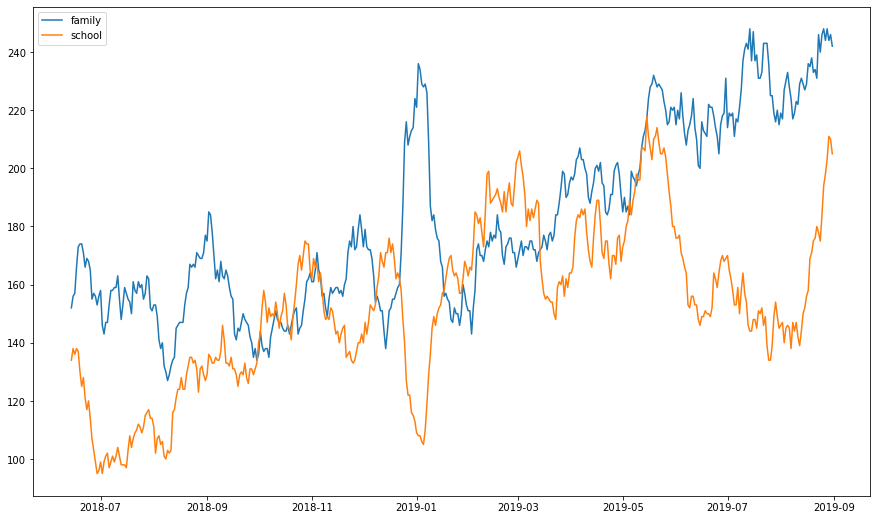

In [366]:
plt.figure(figsize=[15,9])
df_temp = doc_topic_full.groupby(doc_topic_full.date.dt.date)['max_topic'].value_counts().to_frame()
df_temp.columns = ['max topic count']
df_temp = df_temp.reset_index()
x = df_temp[df_temp.max_topic == 'family'].date 
y = df_temp[df_temp.max_topic == 'family']['max topic count'].rolling(15).sum()
x2 = df_temp[df_temp.max_topic == 'school'].date 
y2 = df_temp[df_temp.max_topic == 'school']['max topic count'].rolling(15).sum()
plt.plot(x,y, label='family')
plt.plot(x2,y2, label='school')
plt.legend()

In [ ]:
# doc_topic = pd.DataFrame(doc_topic)
# doc_topic['post'] = df_full.text_title
# doc_topic.values[2]

In [ ]:
# nmf.components_

In [156]:
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

In [157]:
# cnt_vectorizer = CountVectorizer(
#                              strip_accents='unicode',
#                              min_df = 11,
#                              ngram_range=(1, 1),
#                              max_df = .5, 
#                              token_pattern = r'\b[a-zA-Z]{3,}\b',
#                              stop_words = additional_stop_words
# )

# corpus = a
# doc_term2 = cnt_vectorizer.fit_transform(corpus).toarray()

In [158]:
testing = df_full.text_title.reset_index().drop(columns=['index']).text_title.to_frame()
testing

,text_title
0,depression healed 80% in 2 days (cant imagine ...
1,i fucked up today. i was doing really well off...
2,"it's one of the happiest moments of my life, a..."
3,"i cannot do living, i have no one to talk to, ..."
4,almost died today so i was riding my bicycle t...
...,...
58796,i think im becoming a shittier person im 25. i...
58797,"if you find this, here's why i'm scared. a fri..."
58798,i keep stopping my medication i just don’t wan...
58799,do you ever think about something like “what i...


In [159]:
words = list(np.asarray(vectorizer.get_feature_names()))

In [166]:
anch_words = [['school'],
              ['sleep'],
              ['friends', 'lonely'],
              ['kill', 'suicide'],
              ['work','job'],
              ['mom','dad'],
              ['motivation', 'loss']]



In [167]:
list(anch_words)

[['school'],
 ['sleep'],
 ['friends', 'lonely'],
 ['kill', 'suicide'],
 ['work', 'job'],
 ['mom', 'dad'],
 ['motivation', 'loss']]

In [162]:
# p_y_given_x = np.random.random((58801, len(words)))
# p_y_given_x.shape

# for j, a in enumerate(anch_words):
#     p_y_given_x[:, j] = 0.5 * p_y_given_x[:, j] + 0.5 * X[:, a].mean(axis=1).A1

In [168]:
import scipy.sparse as ss
doc_term2 = ss.csr_matrix(doc_term)

In [169]:
anchored_topic_model = ct.Corex(n_hidden=9, seed=1, verbose=False)
anchored_topic_model.fit(doc_term2, words=words, anchors=anch_words, anchor_strength=6, docs=testing)




In [171]:
topics = anchored_topic_model.get_topics(n_words=50)
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: school,high,grades,classes,class,grade,college,semester,teachers,teacher,middle,junior,senior,graduate,bullied,gpa,math,homework,sophomore,study,student,summer,freshman,failed,students,schools,dropped,university,elementary,academic,program,courses,algebra,studying,failing,assignments,exams,highschool,honors,graduating,grad,test,skipping,subjects,finish,bullying,tests,classmates,drop,graduation
1: sleep,wake,awake,asleep,hours,sleeping,tired,night,insomnia,slept,waking,bed,fall,melatonin,dreams,woke,exhausted,morning,apnea,sleepiness,naps,deprivation,nights,nightmares,forever,refreshed,rested,deprived,nap,paralysis,fatigue,lay,tomorrow,daytime,alarms,racing,benzo,sleepy,excessive,alarm,trazodone,dream,oversleeping,drift,peacefully,escape,wide,pillow,incase,recharge
2: lonely,friends,loneliness,hang,hug,hangout,friend,arsed,invite,message,unwanted,medication,doctor,lonelier,somebody,profiles,brain,surrounded,chat,friendless,groups,ignored,extroverted,likes,socialize,contact,busy,tinde

In [377]:
a = df_full.reset_index().drop(columns=['index']).copy()

In [378]:
a

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,...,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,date,text_title
0,1566561445,depression,OdmaSad,self.depression,https://www.reddit.com/r/depression/comments/c...,0,1,NaN,NaN,depression healed 80% in 2 days (cant imagine ...,...,True,NaN,/r/depression/comments/cucv10/depression_heale...,NaN,NaN,False,NaN,NaN,2019-08-23 06:57:25,depression healed 80% in 2 days (cant imagine ...
1,1549921826,depression,PherMumbles,self.depression,https://www.reddit.com/r/depression/comments/a...,1,2,NaN,NaN,I fucked up today.,...,True,NaN,/r/depression/comments/aplifv/i_fucked_up_today/,NaN,NaN,False,NaN,NaN,2019-02-11 15:50:26,i fucked up today. i was doing really well off...
2,1542507204,depression,almieeve95,self.depression,https://www.reddit.com/r/depression/comments/9...,0,1,NaN,NaN,"It's one of the happiest moments of my life, a...",...,True,NaN,/r/depression/comments/9y2b9u/its_one_of_the_h...,NaN,NaN,False,NaN,NaN,2018-11-17 20:13:24,"it's one of the happiest moments of my life, a..."
3,1528072984,depression,[deleted],self.depression,https://www.reddit.com/r/depression/comments/8...,2,3,NaN,NaN,"I cannot do living, I have no one to talk to, ...",...,True,NaN,/r/depression/comments/8od5x1/i_cannot_do_livi...,NaN,NaN,False,NaN,NaN,2018-06-03 19:43:04,"i cannot do living, i have no one to talk to, ..."
4,1556038373,depression,FgBeeK,self.depression,https://www.reddit.com/r/depression/comments/b...,4,3,NaN,NaN,Almost died today,...,True,NaN,/r/depression/comments/bgiq5i/almost_died_today/,NaN,NaN,False,NaN,NaN,2019-04-23 11:52:53,almost died today so i was riding my bicycle t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58796,1543541348,depression,Envoy_of_Doge,self.depression,https://www.reddit.com/r/depression/comments/a...,2,3,NaN,NaN,I think im becoming a shittier person,...,True,NaN,/r/depression/comments/a1nq5e/i_think_im_becom...,NaN,NaN,False,NaN,NaN,2018-11-29 19:29:08,i think im becoming a shittier person im 25. i...
58797,1563396781,depression,EmotionalDragonfruit,self.depression,https://www.reddit.com/r/depression/comments/c...,2,3,NaN,NaN,"If you find this, here's why I'm scared.",...,True,NaN,/r/depression/comments/ceiob9/if_you_find_this...,NaN,NaN,False,NaN,NaN,2019-07-17 15:53:01,"if you find this, here's why i'm scared. a fri..."
58798,1561336351,depression,[deleted],self.depression,https://www.reddit.com/r/depression/comments/c...,0,2,NaN,NaN,I keep stopping my medication,...,True,NaN,/r/depression/comments/c4ffcc/i_keep_stopping_...,NaN,NaN,False,NaN,NaN,2019-06-23 19:32:31,i keep stopping my medication i just don’t wan...
58799,1566592660,depression,rollinthroughdacrap,self.depression,https://www.reddit.com/r/depression/comments/c...,6,7,NaN,NaN,Do you ever think about something like “what i...,...,True,NaN,/r/depression/comments/cujk3e/do_you_ever_thin...,NaN,NaN,False,NaN,NaN,2019-08-23 15:37:40,do you ever think about something like “what i...


In [454]:

import gensim

documents = a.text_title

# documents = topic_doc_df.sort_values(by=['dietary_related'], ascending=False).text_title.head(10000)
# documents = topic_doc_df[topic_doc_df.max_label == 'suicide'].text_title
tokenized_docs = [gensim.utils.simple_preprocess(d) for d in documents]
model = gensim.models.Word2Vec(tokenized_docs, size=500, window=5, min_count=5, sg=1)

In [191]:
man_wom = model.wv['psychiatrist'] - model.wv['counselor']
model.wv.similar_by_vector(man_wom,topn=20)

NameError: name 'model' is not defined

In [481]:
man_wom = model.wv['psychiatrist'] - model.wv['meds'] 
model.wv.similar_by_vector(man_wom,topn=20)
# gend = model.wv['gender']
# cos_sim=np.dot(man_wom,gend)/(np.linalg.norm(man_wom)*np.linalg.norm(gend))
# cos_sim

[('psychiatrist', 0.5493425130844116),
 ('counselor', 0.39136990904808044),
 ('psychologist', 0.3893570303916931),
 ('therapist', 0.38586917519569397),
 ('counsellor', 0.3324766159057617),
 ('gp', 0.3323203921318054),
 ('doctor', 0.32175809144973755),
 ('professor', 0.2867514491081238),
 ('employer', 0.2819126844406128),
 ('specialist', 0.27541035413742065),
 ('receptionist', 0.2616402804851532),
 ('shrink', 0.26017946004867554),
 ('nurse', 0.2582302391529083),
 ('discuss', 0.258129745721817),
 ('referral', 0.25650033354759216),
 ('psychotherapist', 0.2535041272640228),
 ('councillor', 0.25089460611343384),
 ('neurologist', 0.2418125867843628),
 ('referred', 0.23912878334522247),
 ('visit', 0.23890981078147888)]

In [523]:
man_wom = model.wv['sexual'] - model.wv['abuse'] 
model.wv.similar_by_vector(man_wom,topn=20)

[('sexual', 0.5786385536193848),
 ('sex', 0.30601418018341064),
 ('romantic', 0.3009510338306427),
 ('attraction', 0.25670623779296875),
 ('romance', 0.2540687918663025),
 ('intimate', 0.23876428604125977),
 ('platonic', 0.23355022072792053),
 ('sexy', 0.22726386785507202),
 ('asexual', 0.22070923447608948),
 ('romantically', 0.22001400589942932),
 ('gender', 0.2171054482460022),
 ('intimacy', 0.213119238615036),
 ('weird', 0.20959262549877167),
 ('initiate', 0.2037344127893448),
 ('genuine', 0.20362398028373718),
 ('meaningful', 0.2035132199525833),
 ('nsfw', 0.20317038893699646),
 ('wtf', 0.1992827206850052),
 ('sparks', 0.19914460182189941),
 ('libido', 0.198710635304451)]

In [520]:
man_wom = model.wv['zelda'] + model.wv['anime'] 
model.wv.similar_by_vector(man_wom,topn=20)

[('anime', 0.9673102498054504),
 ('manga', 0.8279320001602173),
 ('animes', 0.8219760060310364),
 ('cartoons', 0.8140982389450073),
 ('reruns', 0.7986899614334106),
 ('mtg', 0.7923787236213684),
 ('documentaries', 0.7857716083526611),
 ('competitively', 0.7761529684066772),
 ('vidya', 0.7746255993843079),
 ('films', 0.7710013389587402),
 ('airsoft', 0.7671270370483398),
 ('novels', 0.7621896266937256),
 ('youtubers', 0.7619882822036743),
 ('comics', 0.7605994939804077),
 ('yugioh', 0.7584125399589539),
 ('streamer', 0.7525142431259155),
 ('animated', 0.7509921193122864),
 ('gta', 0.7477341294288635),
 ('skyrim', 0.7477177381515503),
 ('television', 0.7476757764816284)]

In [539]:
man_wom = model.wv['exhausted'] + model.wv['bored'] 
model.wv.similar_by_vector(man_wom,topn=20)

[('bored', 0.848865270614624),
 ('exhausted', 0.8171983957290649),
 ('drained', 0.6808281540870667),
 ('tired', 0.6539965867996216),
 ('demotivated', 0.6155556440353394),
 ('fatigued', 0.6125768423080444),
 ('existentially', 0.6002424955368042),
 ('uninspired', 0.5903615951538086),
 ('lethargic', 0.5896291732788086),
 ('listless', 0.5873421430587769),
 ('restless', 0.5865349769592285),
 ('overwhelmed', 0.5744432210922241),
 ('achy', 0.5707709789276123),
 ('uninterested', 0.5688700079917908),
 ('frustrated', 0.565231204032898),
 ('exhausts', 0.5578351020812988),
 ('taxed', 0.5567173361778259),
 ('groggy', 0.5536370277404785),
 ('oversleep', 0.5534212589263916),
 ('disoriented', 0.5520873665809631)]